In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from startup import np, pd, plt, sns
from startup_gui import widgets, interact, interactive

In [3]:
import pzflow
import tensorflow_probability.substrates.jax as tfp

In [140]:
import jax

In [141]:
import jax.numpy as jnp

In [4]:
import os
from io import StringIO
from dataclasses import dataclass

In [16]:
from sklearn.model_selection import train_test_split

In [5]:
from journal_20231211_nf_functions import MafData, MafDataOriginal

In [132]:
tfd = tfp.distributions
tfb = tfp.bijectors

# POWER
From [UCI 
Individual household electric power consumption](https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption) dataset.  

This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months).

## Notes:


 1.(global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured isub-meterings 1, 2 and 3.

2. 
2.The dataset contains some missing values in the measurements (nearl. 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 200

# Data Import

## Data Details
We can either use the original UCI data or the pre-processed data from [Preprocessed datasets for MAF experiments](https://zenodo.org/records/1161203#.Wmtf_XVl8eN).  The latter removes the date column and adds small amounts of noise to all columns to ensure continuous distributions as described below.

From [A note on the evaluation of generative models](https://arxiv.org/abs/1511.01844)
> Since the discrete data distribution has differential entropy of negative infinity, this can lead to arbitrary high likelihoods even on test data. To avoid this case, it is becoming best practice to add real-valued noise to the integer pixel values to dequantize the data (e.g., Uria et al., 2013; van den Oord & Schrauwen, 2014; Theis & Bethge, 2015).

## Original Data

In [6]:
maf_data = MafDataOriginal()

In [7]:
df = maf_data.power

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2049280 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 8 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   global_active_power    float64
 1   global_reactive_power  float64
 2   voltage                float64
 3   global_intensity       float64
 4   kitchen                float64
 5   laundry                float64
 6   heating                float64
 7   other                  float64
dtypes: float64(8)
memory usage: 140.7 MB


In [9]:
interactive(
    lambda date: sns.lineplot(
        df.resample('5min').mean()[date:date+pd.Timedelta('1D')], 
        x='timestamp', y='global_active_power', hue='kitchen'
    ),
    date = widgets.DatePicker(description='Date', value=df.index.min().date())
)

interactive(children=(DatePicker(value=datetime.date(2006, 12, 16), description='Date', step=1), Output()), _d…

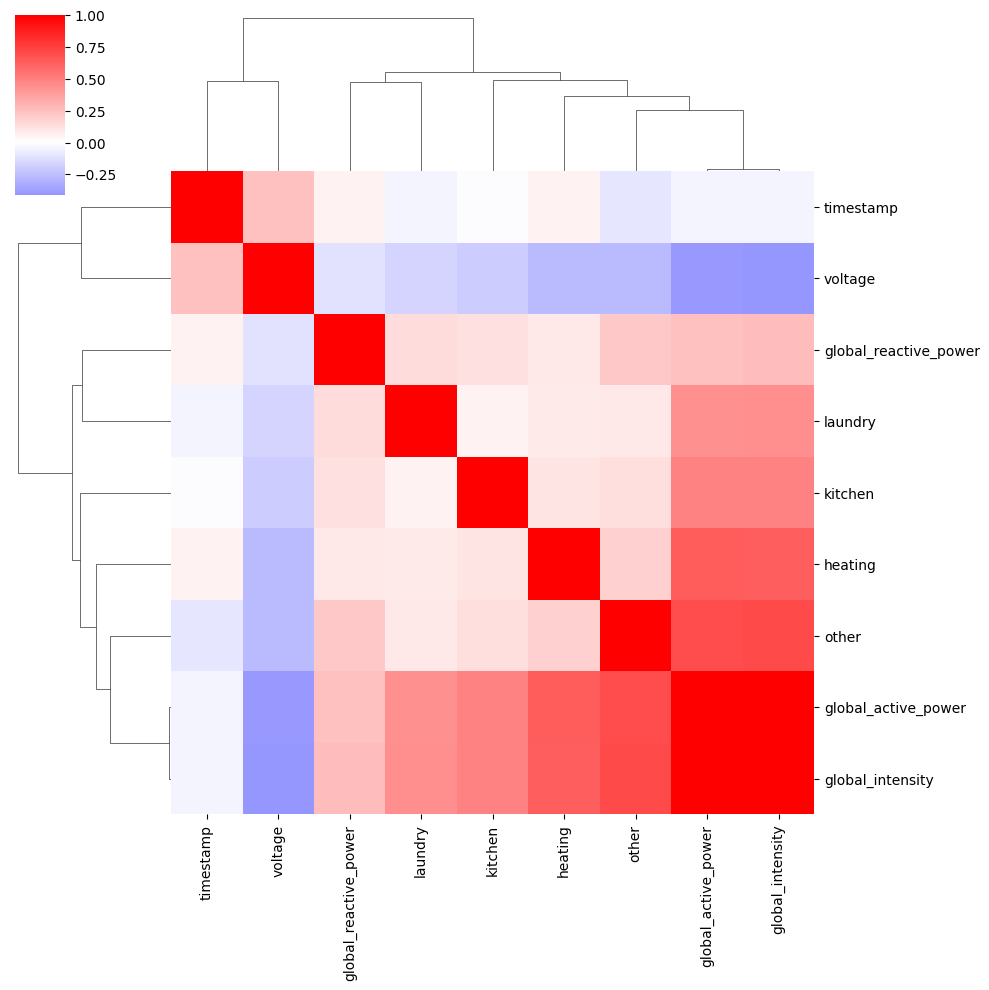

In [10]:
sns.clustermap(df.reset_index().corr(), cmap='bwr', center=0)

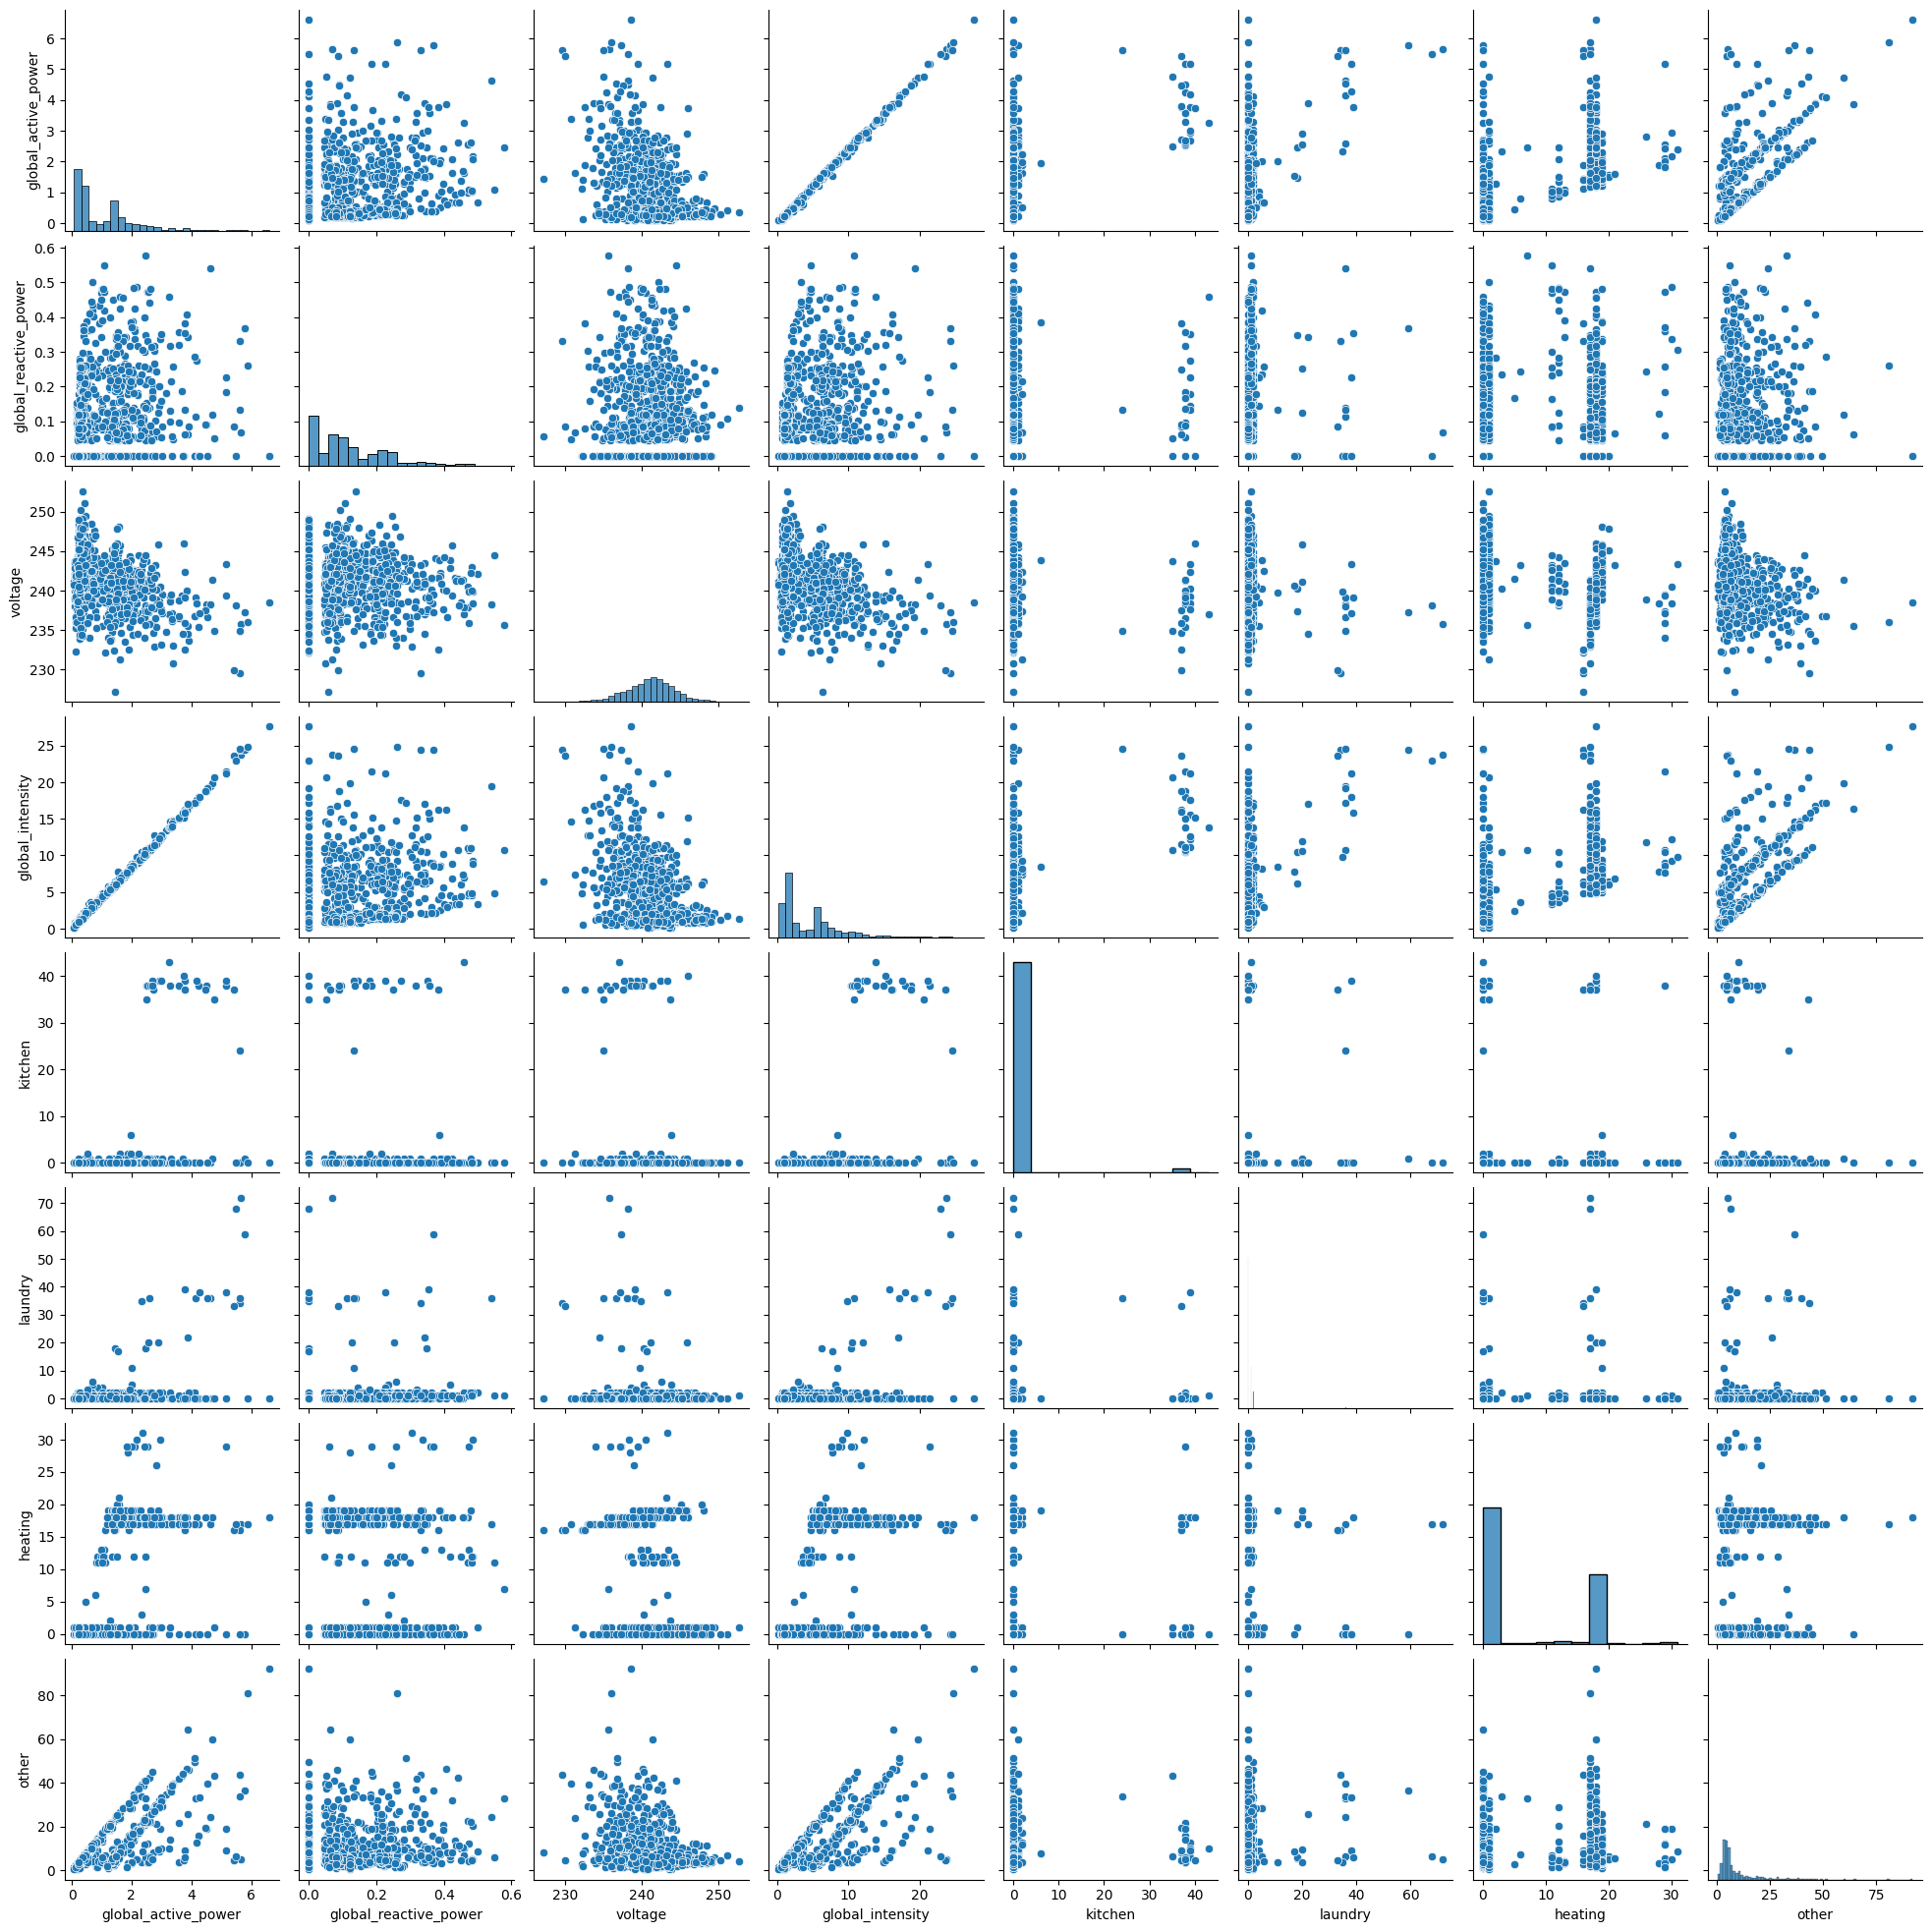

In [11]:
sns.pairplot(df.sample(1000))

In [12]:
df.assign(
    vi=lambda x: x.voltage*x.global_intensity/1000, 
    total_power=lambda x: x.global_active_power + x.global_reactive_power
).head()

,global_active_power,global_reactive_power,voltage,global_intensity,kitchen,laundry,heating,other,vi,total_power
timestamp,,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266667,4.321056,4.634
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333333,5.373490,5.796
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566667,5.365670,5.872
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800000,5.376020,5.890
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.100000,3.723744,4.194


# PZFlow - fitting joint distribution

In [48]:
vars = 'global_active_power,global_reactive_power,voltage,global_intensity,kitchen,laundry,heating,other'.split(',')

In [49]:
len(df.loc['2007'])

521669

In [50]:
df_train = df.loc['2007'].sample(100_000).reset_index()
df_val = df.loc['2007'].sample(10_000).reset_index()
df_val = df_val.loc[~df_val.timestamp.isin(df_train.timestamp), :]
print(len(df_train), len(df_val))

100000 8095


In [42]:
fname = 'power_flow_20231213.pzflow.pkl'
run_pzflow = False
if os.path.isfile(fname):
    flow = pzflow.Flow(file=fname)
else:
    run_pzflow = True
    flow.info = 'Example running PZFlow on POWER data from MAF paper, using original UCI dataset'

In [43]:
if run_pzflow:
    flow = pzflow.Flow(vars)
    losses = flow.train(df_train, val_set=df_val, verbose=True)
    sns.lineplot(losses)
    flow.save("power_flow_20231213.pzflow.pkl")

In [44]:
samples = flow.sample(1_000)

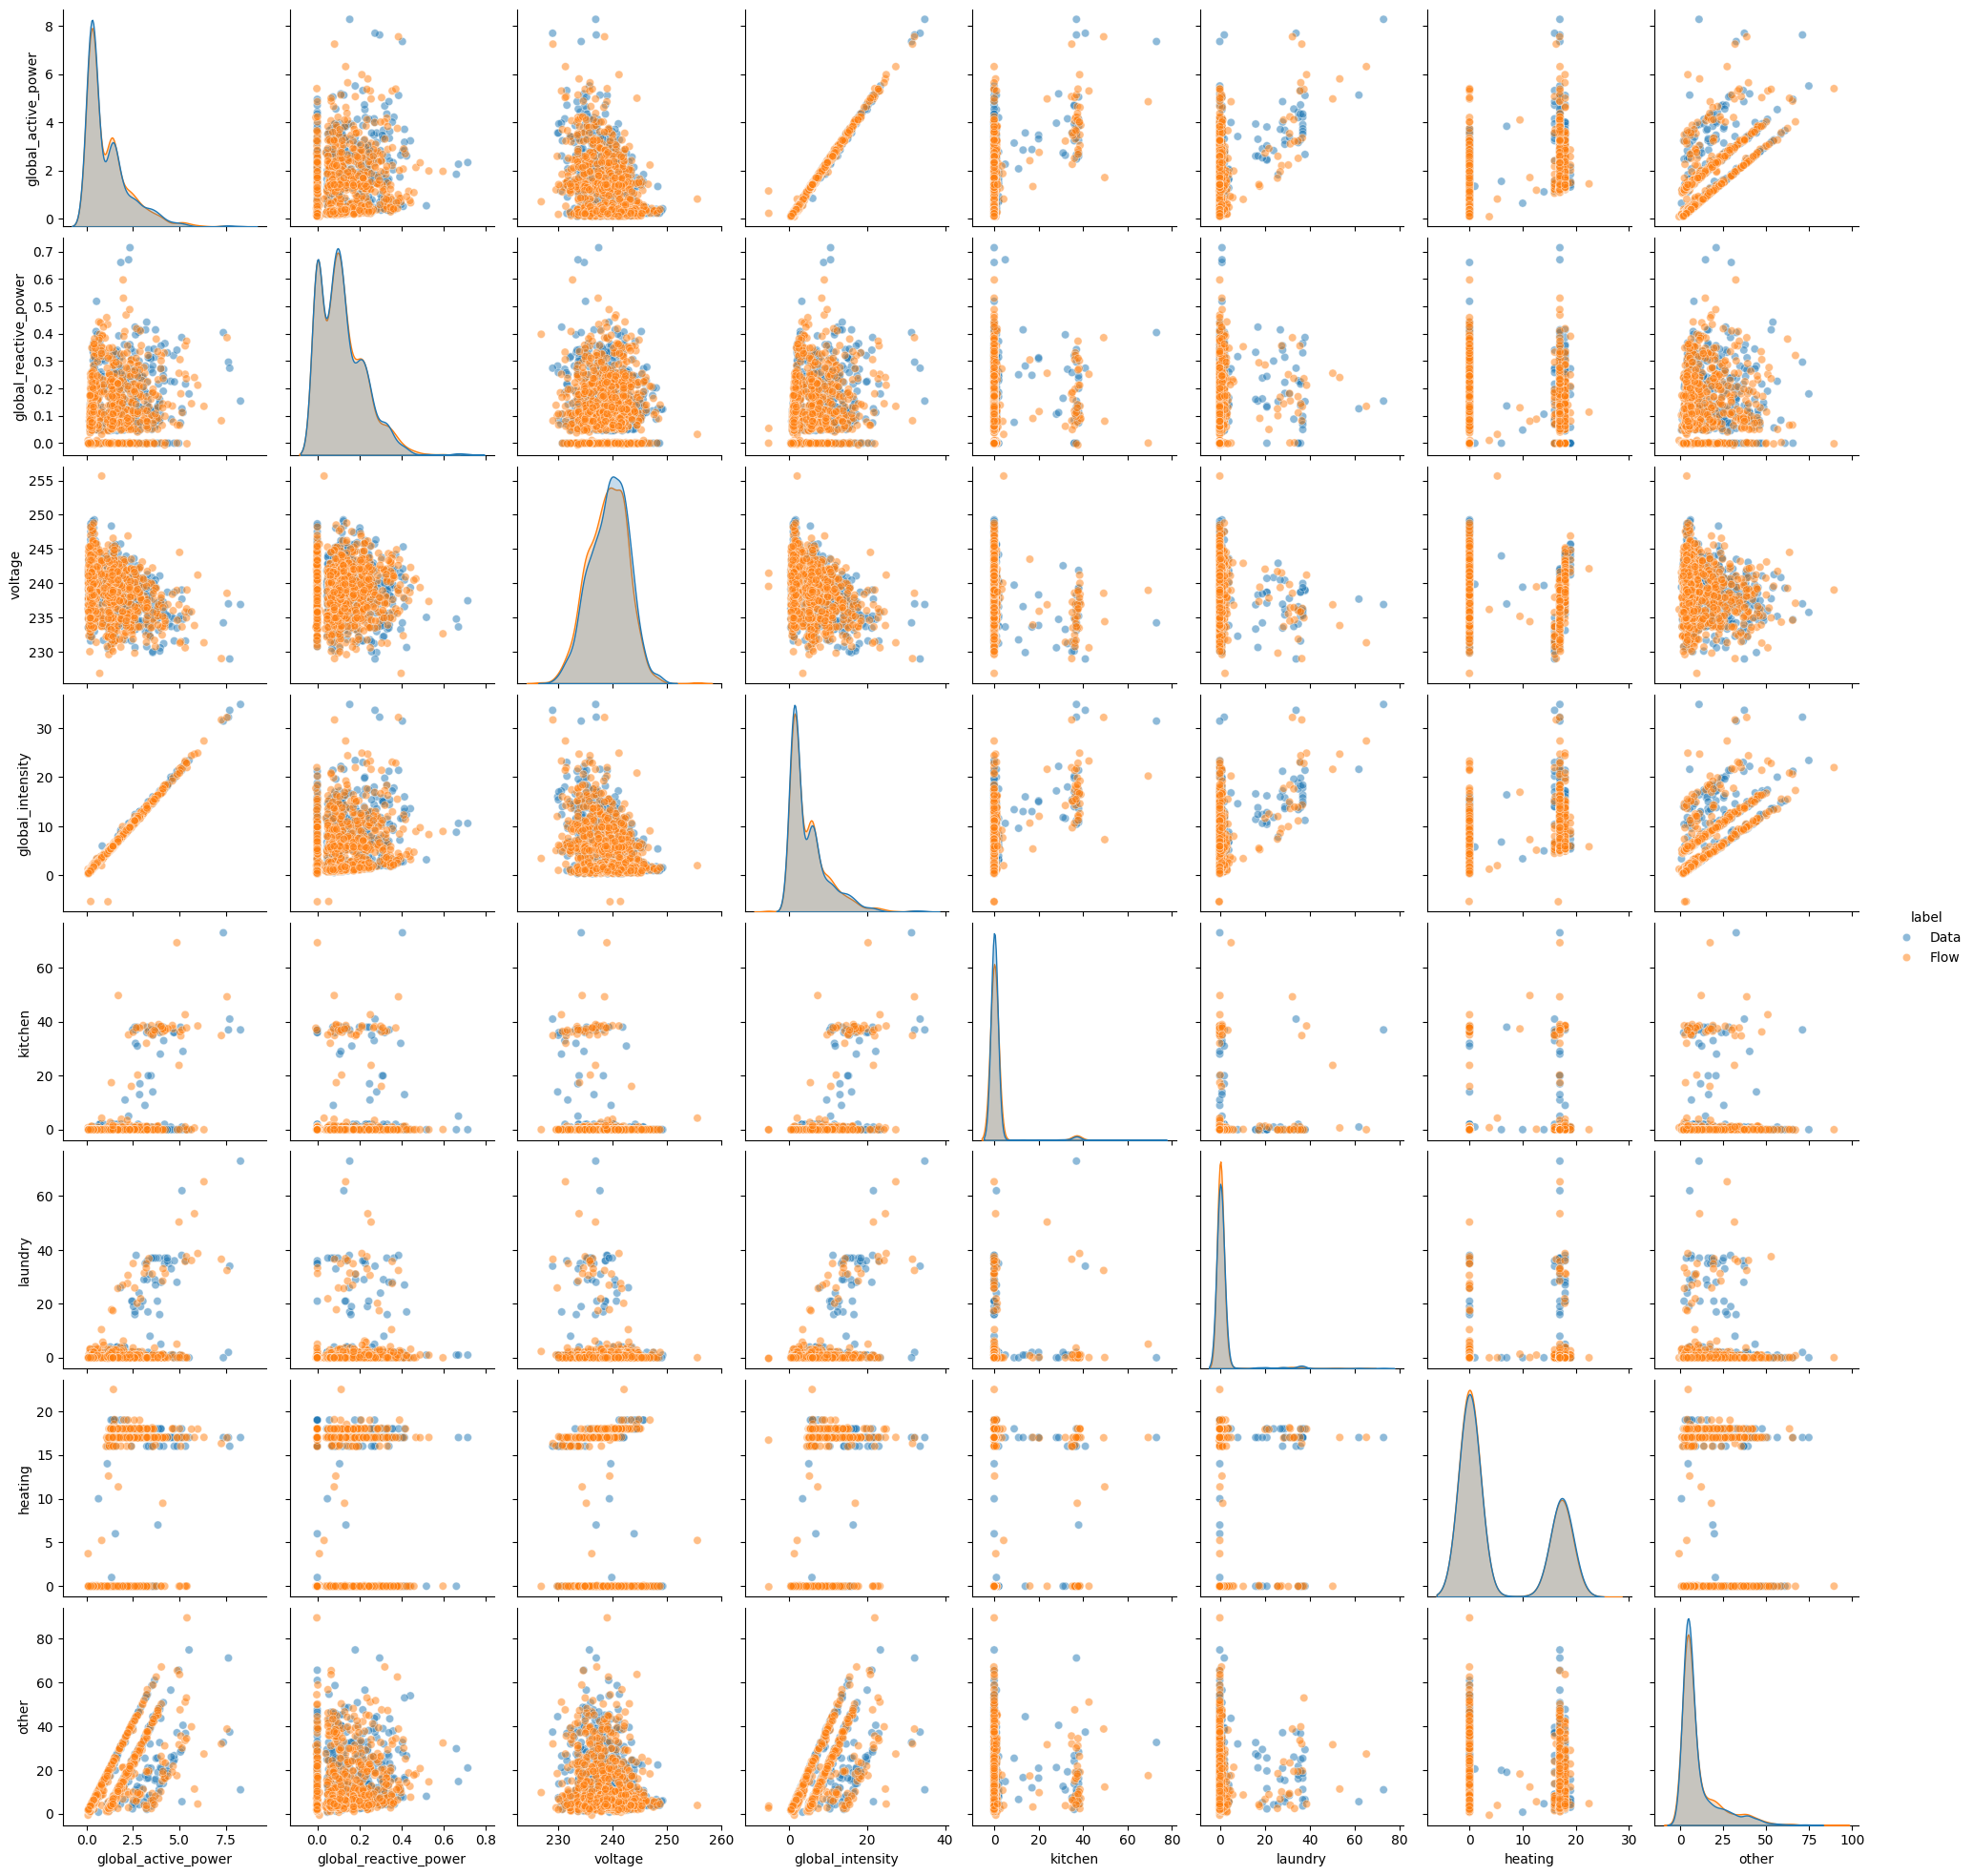

In [45]:
sns.pairplot(
    pd.concat(
        [ df_train.loc[:, vars].sample(1000).assign(label='Data'),
        samples.assign(label='Flow')]
    ),
    hue='label', plot_kws={'alpha': 0.5}
)

In [47]:
flow._bijector_info

('Chain',
 (('ShiftBounds',
   (Array([ 8.2000e-02,  0.0000e+00,  2.2349e+02,  4.0000e-01,  0.0000e+00,
            0.0000e+00,  0.0000e+00, -2.4000e+00], dtype=float32),
    Array([ 10.67    ,   1.148   , 252.14    ,  46.4     ,  78.      ,
            78.      ,  20.      , 122.166664], dtype=float32),
    4.0)),
  ('Chain',
   (('NeuralSplineCoupling', (16, 5, 2, 128, None, 0, False)),
    ('Roll', (1,)),
    ('NeuralSplineCoupling', (16, 5, 2, 128, None, 0, False)),
    ('Roll', (1,)),
    ('NeuralSplineCoupling', (16, 5, 2, 128, None, 0, False)),
    ('Roll', (1,)),
    ('NeuralSplineCoupling', (16, 5, 2, 128, None, 0, False)),
    ('Roll', (1,)),
    ('NeuralSplineCoupling', (16, 5, 2, 128, None, 0, False)),
    ('Roll', (1,)),
    ('NeuralSplineCoupling', (16, 5, 2, 128, None, 0, False)),
    ('Roll', (1,)),
    ('NeuralSplineCoupling', (16, 5, 2, 128, None, 0, False)),
    ('Roll', (1,)),
    ('NeuralSplineCoupling', (16, 5, 2, 128, None, 0, False)),
    ('Roll', (1,))))))

# PZFlow - fitting joint distribution conditioned on hour of day and month of year

In [51]:
def add_hour_month_cols(df):
    return df.assign(
        hour=lambda x: x.timestamp.dt.hour,
        month=lambda x: x.timestamp.dt.month,
    )        

In [54]:
df_train = df.loc['2007'].sample(100_000).reset_index().pipe(add_hour_month_cols)
df_val = df.loc['2007'].sample(10_000).reset_index().pipe(add_hour_month_cols)
df_val = df_val.loc[~df_val.timestamp.isin(df_train.timestamp), :]
print(len(df_train), len(df_val))

100000 8020


In [55]:
fname = 'power_flow_hour_month_20231213.pzflow.pkl'
run_pzflow = False
if os.path.isfile(fname):
    flow = pzflow.Flow(file=fname)
else:
    run_pzflow = True
    flow.info = 'Example running PZFlow on POWER data from MAF paper, using original UCI dataset.  Condition on hour and month'


Training 100 epochs 
Loss:
(0) 29.6276  29.6107
(1) 4.7675  4.6829
(6) 1.0133  0.9429
(11) -2.7986  -2.8699
(16) -3.3087  -3.3823
(21) -5.1200  -5.1591
(26) -5.9099  -5.9738
(31) -4.9226  -5.0062
(36) -6.7431  -6.7891
(41) -5.4961  -5.5318
(46) -1.7590  -1.7793
(51) -8.4026  -8.4386
(56) -6.8869  -6.9068
(61) -7.3137  -7.3415
(66) -8.1321  -8.1845
(71) -5.9084  -5.8869
(76) -7.8983  -7.9362
(81) -5.9696  -5.9622
(86) -6.3542  -6.3835
(91) -6.3940  -6.4174
(96) -10.3274  -10.3288
(100) -7.0725  -7.0860


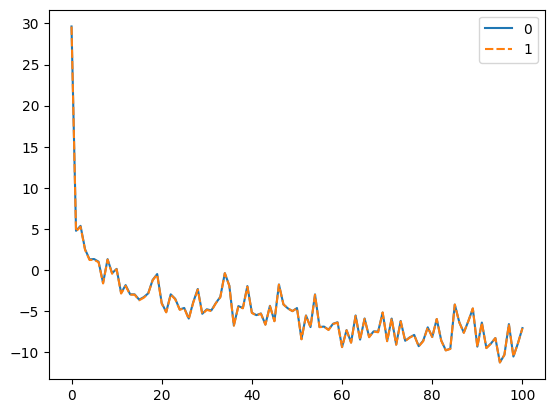

In [56]:
if run_pzflow:
    flow = pzflow.Flow(vars, conditional_columns=['hour', 'month'])
    losses = flow.train(df_train, val_set=df_val, verbose=True)
    sns.lineplot(losses)
    flow.save("power_flow_hour_month_20231213.pzflow.pkl")

In [92]:
df_sc = flow.sample(10_000, conditions=pd.DataFrame({'hour': range(24), 'month': [1]*24}))

<Axes: xlabel='global_active_power', ylabel='hour'>

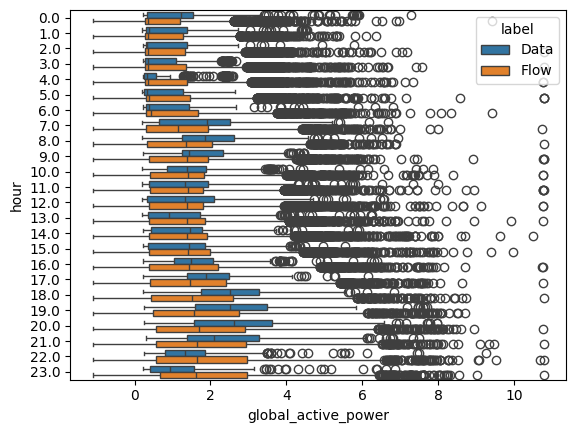

In [94]:
sns.boxplot(
    pd.concat([df_train.query('month == 1').assign(label='Data'), df_sc.assign(label='Flow')]), 
    x='global_active_power', y='hour', hue='label', orient='y'
)

In [135]:
# flow._bijector_info

In [134]:
# [x.shape for x in jax.tree_util.tree_leaves(flow._params)]

# TensorFlow Probability 
Initial exploration, continued in [journal_20231214_nf_tfp_gui](journal_20231214_nf_tfp_gui.ipynb)

In [179]:
batch_size = 512
key, subkey = jax.random.split(jax.random.PRNGKey(42))
x2_dist = tfd.Normal(loc=0., scale=4.)
x2_samples = x2_dist.sample(batch_size, seed=subkey)
x1_dist = tfd.Normal(loc=0.25 * jnp.square(x2_samples), scale=jnp.ones(batch_size, dtype=jnp.float32))
key, subkey = jax.random.split(key)
x1_samples = x1_dist.sample(seed=key)
x_sample = jnp.stack([x1_samples, x2_samples], axis=1)

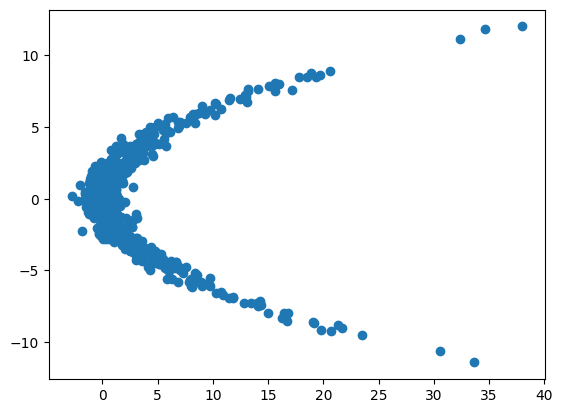

In [180]:
plt.scatter(x_sample[:,0], x_sample[:,1])

In [230]:
dist = tfd.JointDistributionSequential(
    [
        tfd.Normal(loc=0., scale=4., name='x2'),
        lambda x2: tfd.Normal(loc=0.25*jnp.square(x2), scale=1., name='x1')
    ],
    use_vectorized_map=True, batch_ndims=0
)
print(f'Batch shape: {dist.batch_shape}, Event shape: {dist.event_shape}')

Batch shape: (), Event shape: [TensorShape([]), TensorShape([])]


In [231]:
x2, x1 = dist.sample(batch_size, seed=key)

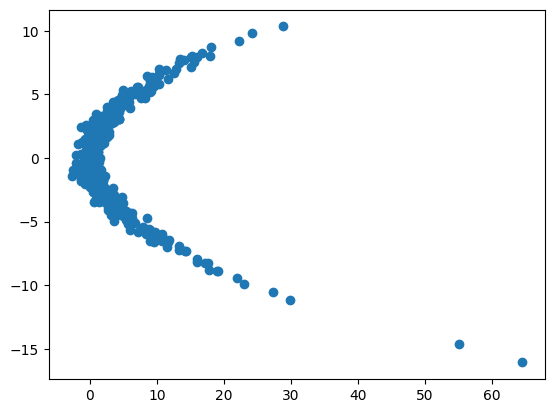

In [232]:
plt.scatter(x1, x2)

In [233]:
dist.resolve_graph()

(('x2', ()), ('x1', ('x2',)))

In [234]:
x2.shape

(512,)

In [224]:
# indep_dist = tfd.Independent(distribution=dist, reinterpreted_batch_ndims=1)
# print(f'Batch shape: {indep_dist.batch_shape}, Event shape: {indep_dist.event_shape}')